In [93]:
import pyterrier as pt  # type: ignore
import os
import yaml
from tira.third_party_integrations import persist_and_normalize_run, ensure_pyterrier_is_loaded
import pandas as pd
from trectools import TrecRun, TrecQrel, TrecEval

from trectools import TrecQrel, procedures

ensure_pyterrier_is_loaded()

In [94]:
test_run = pd.DataFrame([
    {"system": "1", "query": "q06223196", "q0": "Q0", "docid": "doc062200204465", "rank": 1, "score": 0}, 
    {"system": "1", "query": "q06223196", "q0": "Q0", "docid": "doc062200112743", "rank": 2, "score": -1},
    
    {"system": "1", "query": "q062219244", "q0": "Q0", "docid": "doc062200108085", "rank": 1, "score": 1},
    {"system": "1", "query": "q062219244", "q0": "Q0", "docid": "doc062200106015", "rank": 2, "score": -1},


    {"system": "2", "query": "q06223196", "q0": "Q0", "docid": "doc062200112743", "rank": 1, "score": 0}, 
    {"system": "2", "query": "q06223196", "q0": "Q0", "docid": "doc062200204465", "rank": 2, "score": -1},
    
    {"system": "2", "query": "q062219244", "q0": "Q0", "docid": "doc062200106015", "rank": 1, "score": 1},
    {"system": "2", "query": "q062219244", "q0": "Q0", "docid": "doc062200108085", "rank": 2, "score": -1},
    ])

In [95]:
def load_doc_translation():
    ret = pd.read_csv("data/core_docs.tsv", sep="\t")
    return {i['docno_WT']: {'WT': i['docno_WT'], 'LT': i['docno_LT'], 'ST': i['docno_ST']} for _, i in ret.iterrows()}

doc_translation = load_doc_translation()

In [96]:
def load_query_translation(target_corpus):
    ret = pd.read_csv("data/core_queries.tsv", sep="\t")
    return {i[f'qid_{target_corpus}']: i['qid_WT'] for _, i in ret.iterrows()}


def sorted_training_data_for_query(qid):
    ret_train = pd.read_csv("data/publish/French/Qrels/train.txt", names=["qid", "Q0", "docno", "relevance"], sep=" ")
    ret_test = pd.read_csv("data/longeval-relevance-judgements/heldout-test.txt", names=["qid", "Q0", "docno", "relevance"], sep=" ")
    
    ret = pd.concat([ret_train, ret_test])
    return ret[ret["qid"].astype(str)==qid].sort_values("relevance", ascending=False)


def ground_truth_ranking_from_training_data(qid):
    mapping = {"q06": "WT", "q07": "ST", "q09": "LT"}
    target_corpus = mapping[qid[:3]]
    query_mapping = load_query_translation(target_corpus)
    
    training_data = sorted_training_data_for_query(query_mapping[qid])

    training_data["translated"] = training_data["docno"].apply(lambda i: doc_translation.get(i, {}).get(target_corpus, None))
    training_data = training_data.dropna()
    return pd.DataFrame([{'qid': qid, 'docno': i['translated'], 'score': i['relevance']} for _, i in training_data.iterrows()])

In [97]:
def ground_truth_ranking_from_training_data_transformer(df):
    qids = df["qid"].unique()
    qid_to_query = {i['qid']: i['query'] for _, i in df.iterrows()}

    ret = []
    for qid in qids:
        ranking = ground_truth_ranking_from_training_data(qid)

        if len(ranking)> 0:
            ranking["query"] = ranking['qid'].apply(lambda i: qid_to_query[i])
        ret.append(ranking)
    return pd.concat(ret)

In [98]:
def qrels_for_query(qid):
    ground_truth = ground_truth_ranking_from_training_data(qid)
    ground_truth = ground_truth.rename(columns={"qid": "query", "docno": "docid", "score": "rel"})
    ground_truth["q0"] = "q0"
    ret = TrecQrel()
    ret.qrels_data = ground_truth
    return ret

In [99]:
def get_run_by_system(qid, system, all_runs):
    run = all_runs[(all_runs["qid"] == qid) & (all_runs["system"]==system)].copy()
    run = run.rename(columns = {"query": "query_string"})
    run = run.rename(columns = {"qid": "query", "docno": "docid"})
    ret = TrecRun()
    ret.run_data = run
    return ret

In [100]:
def calculate_score_of_system_on_query(qid, all_runs, system, measure="NDCG_5"):
    try:
        qrels = qrels_for_query(qid)
        run = get_run_by_system(qid, system, all_runs)
        
        ret = TrecEval(run, qrels).get_ndcg(depth=10, removeUnjudged=True)
    except:
        print(qid)
        return -1
    return ret

In [101]:
def select_best_system_per_query(qid, all_runs, measure="NDCG_5"):
    systems = all_runs["system"].unique()
    best_system = None
    best_score = None

    for system in systems:
        score_of_system = calculate_score_of_system_on_query(qid, all_runs, system)
        if best_system is None or best_score < score_of_system:
            best_system = system
            best_score = score_of_system
    return best_system

In [102]:
def build_run(all_runs):
    ret = []
    for qid in all_runs["qid"].unique():
        best_system = select_best_system_per_query(qid, all_runs)
        ret.append(all_runs[(all_runs["qid"] == qid) & (all_runs["system"]==best_system)].copy())

    return pd.concat(ret)

# Create Runs

In [124]:
def load_runs(system_name):
    ret = []
    for subcollection in ["WT", "ST", "LT"]:
        ret.append(pt.io.read_results(f"results/test/{system_name}.{subcollection}"))
    ret.append(pt.io.read_results(f"results/train/{system_name}.WT"))
    return pt.Transformer.from_df(pd.concat(ret).sort_values(["qid", "rank"]))


In [104]:
with open(os.path.join(".", "settings.yml"), "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

In [13]:
core_queries = pd.read_csv("data/core_queries.tsv", sep="\t")

In [14]:
for subcollection in ["LT", "ST"]:
    index = pt.IndexFactory.of(os.path.join(".", config["index_dir"] + f"index_{subcollection}"))
    
    topics = pt.io.read_topics(config[subcollection]["test"]["topics"])
    topics = topics[topics["qid"].isin(core_queries[f"qid_{subcollection}"])]

    BM25 = pt.BatchRetrieve(index, wmodel="BM25", verbose=True)
    explicit_relevance_feedback = pt.apply.generic(ground_truth_ranking_from_training_data_transformer)
    RM3 = pt.rewrite.RM3(index)
    BO1 = pt.rewrite.Bo1QueryExpansion(index)
    E5 = load_runs("IRC_E5_base")
    monoT5 = load_runs("IRC_BM25+monoT5")

    pipeline = [
        ("bm25", BM25),
        ("exp-Rm3-bm25", explicit_relevance_feedback >> RM3 >> BM25),
        ("exp-BO1-bm25", explicit_relevance_feedback >> BO1 >> BM25),
        ("bm25-RM3-bm25", BM25 >> RM3 >> BM25),
        ("bm25-BO1-bm25", BM25 >> BO1 >> BM25),
        # ("E5-BO1-bm25", E5 >> BO1 >> BM25),
        ("E5-RM3-bm25", E5 >> RM3 >> BM25),
        ("monoT5-BO1-bm25", monoT5 >> BO1 >> BM25),
        ("monoT5-RM3-bm25", monoT5 >> RM3 >> BM25),
        ("E5", E5),
        ("monoT5", monoT5)
    ]

    all_runs = []

    for name, system in pipeline:
        run = system(topics)
        run["system"] = name
        run["q0"] = "q0"
        run = run[['qid', "q0", 'docno', 'rank', 'score','system']]
        all_runs.append(run)
        run.to_csv(f"results/fuse_learn/{name}.{subcollection}", index=False, header=False, sep=" ")

    final_run = build_run(pd.concat(all_runs))
    final_run["system"] = "fuse"
    final_run.to_csv(f"results/fuse_learn/fuse.{subcollection}", index=False, header=False, sep=" ")

17:32:12.119 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 2.3 GiB of memory would be required.


BR(BM25): 100%|██████████| 124/124 [02:51<00:00,  1.38s/q]


q09225884
q09225884
q09225884
q09225884
q09225884
q09225884
q09225884
q09225884
q09225884
q09225884
q092232018
q092232018
q092232018
q092232018
q092232018
q092232018
q092232018
q092232018
q092232018
q092232018
18:04:08.182 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 3.4 GiB of memory would be required.


BR(BM25): 100%|██████████| 124/124 [01:53<00:00,  1.10q/s]


q072210934
q072210934
q072210934
q072210934
q072210934
q072210934
q072210934
q072210934
q072210934
q072210934
q072218453
q072218453
q072218453
q072218453
q072218453
q072218453
q072218453
q072218453
q072218453
q072218453


# Evaluate

In [2]:
runs = []
for run in all_runs:
    run = run.rename(columns = {"query": "query_string"})
    run = run.rename(columns = {"qid": "query", "docno": "docid"})
    ret = TrecRun()
    ret.run_data = run
    runs.append(run)


NameError: name 'all_runs' is not defined

In [359]:
def load_qrels(subcollection):
    qrels_file = config[subcollection]["test"]["qrels"]
    qrels = pd.read_csv(qrels_file, names=["query", "Q0", "docid", "rel"], sep=" ")
    qrels = qrels[qrels["query"].isin(core_queries[f"qid_{subcollection}"])]

    ret = TrecQrel()
    ret.qrels_data = qrels
    return ret

In [361]:
def load_runs(subcollection):
    return procedures.list_of_runs_from_path("results/fuse_learn", f"*.{subcollection}")

In [362]:
def fix_nan_in_runs(results_per_system):
    runs_fixed = []
    for system in results_per_system:
        data = system.data.fillna(0)
        system.data = data
        runs_fixed.append(system)
    return runs_fixed


In [363]:
from matplotlib import pyplot as plt

In [368]:
def evaluate(measures):
    for subcollection in ["ST", "LT"]:
        runs = load_runs(subcollection)
        qrels = load_qrels(subcollection)
        
        results_per_system = procedures.evaluate_runs(runs, qrels, per_query=True)
        results_per_system = fix_nan_in_runs(results_per_system)

        for measure in measures:
            results = procedures.extract_metric_from_results(results_per_system, measure)
            fig = procedures.plot_system_rank(results, display_metric=measure)
            plt.title(f"{measure} at {subcollection}")

Found 11 runs in path results/fuse_learn
Found 11 runs in path results/fuse_learn


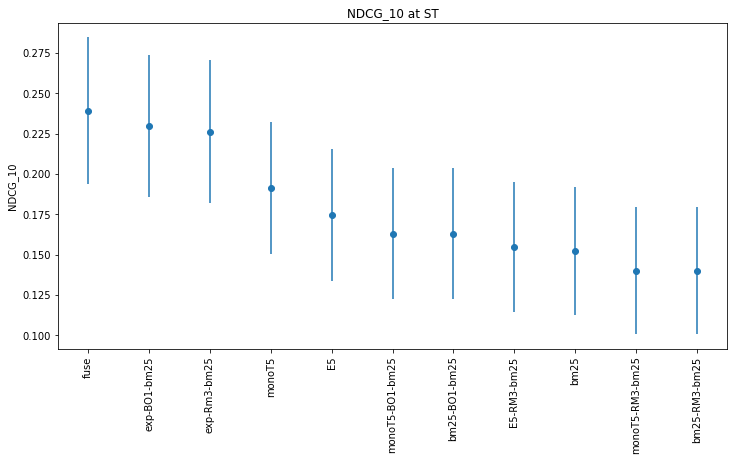

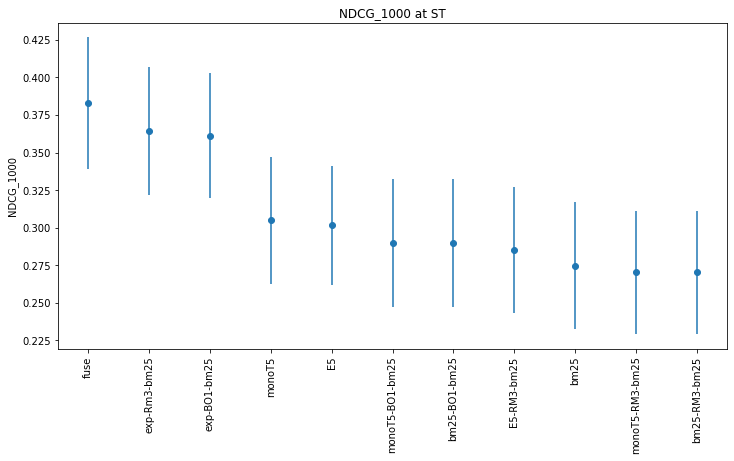

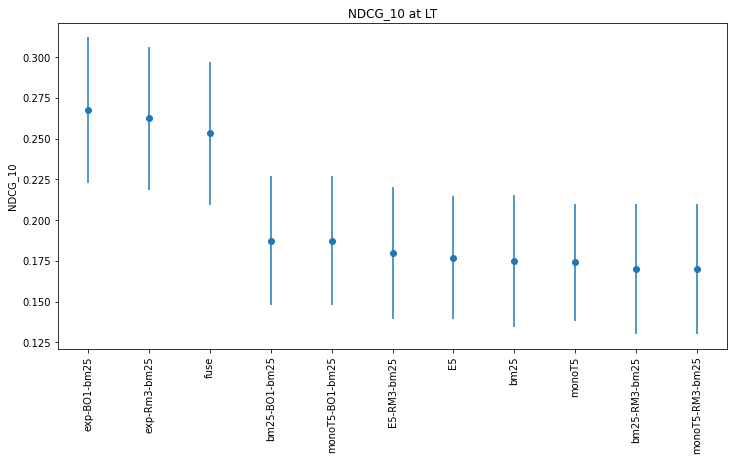

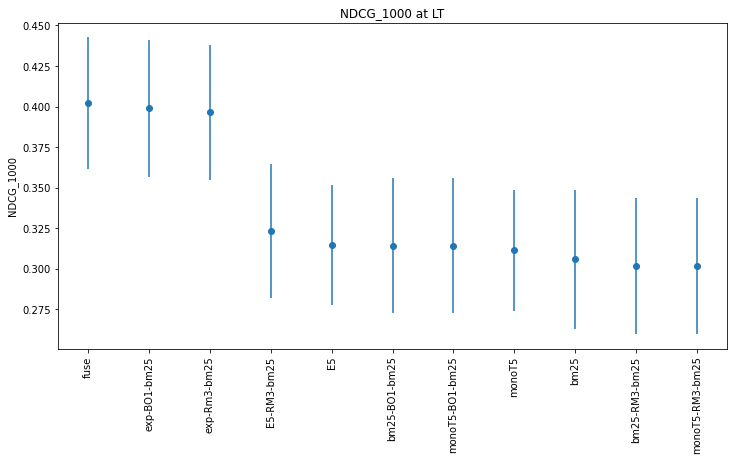

In [369]:
evaluate(measures=["NDCG_10", "NDCG_1000"])